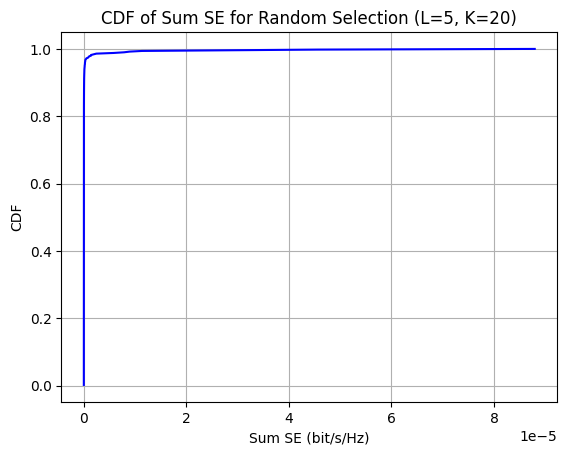

[np.float64(8.149934855080656e-09), np.float64(2.5440822044621243e-10), np.float64(4.6209546107908e-09), np.float64(2.9557371869290442e-08), np.float64(4.2110957037118386e-10), np.float64(6.83889663120362e-08), np.float64(4.518060524420109e-10), np.float64(2.0811171230600523e-07), np.float64(1.960702871233256e-09), np.float64(1.369590243806626e-09), np.float64(3.8986340808810425e-08), np.float64(1.5256847289278784e-10), np.float64(1.3130469150276013e-09), np.float64(7.070269392022336e-08), np.float64(5.364157403112243e-09), np.float64(3.7165658033402335e-09), np.float64(1.5856125098598963e-10), np.float64(3.593852817332772e-09), np.float64(4.315676687206007e-10), np.float64(1.3356102175794659e-09), np.float64(2.8404614597374673e-05), np.float64(2.9961419651306246e-09), np.float64(8.406167215646762e-08), np.float64(7.359204155666799e-10), np.float64(3.081601474884925e-10), np.float64(7.613751628934089e-10), np.float64(7.408530837281554e-10), np.float64(5.242255140127224e-09), np.float64

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L, K, M = 5, 10, 100
tau_c, tau_p = 200, 20
p_d, p_p = 0.2, 0.2
# sigma2 = 2e-20
area_size = 1000  # meters (1 km^2)
num_realizations = 500
PL0, gamma, sigma_shadow = 35.3, 3.76, 8

sum_se = []
for _ in range(num_realizations):
    # Random positions (in meters)
    AP_pos = np.random.rand(L, 2) * area_size
    user_pos = np.random.rand(K, 2) * area_size
    
    # Distances in km
    distances = np.zeros((K, L))
    for k in range(K):
        for l in range(L):
            distances[k, l] = np.linalg.norm(user_pos[k] - AP_pos[l]) / 1000
    
    # Path loss with shadowing (dB)
    z_kl = np.random.normal(0, sigma_shadow, (K, L))
    PL_kl = PL0 + 10 * gamma * np.log10(distances) + z_kl
    beta_kl = 10 ** (-PL_kl / 10)
    
    # Channel estimation
    eta_kl = (p_p * tau_p * beta_kl**2) / (tau_p * p_p * beta_kl + 1)
    
    # Random assignment
    perm = np.random.permutation(K)
    serving_AP = np.random.randint(0, L, size=K)
    U = [[] for _ in range(L)]
    for k in range(K):
        U[serving_AP[k]].append(k)
    
    # User sets per AP
    U = [[] for _ in range(L)]
    for k in range(K):
        U[serving_AP[k]].append(k)
    
    # Sum SE
    total_se = 0
    for k in range(K):
        l_k = serving_AP[k]
        num = M**2 * p_d * eta_kl[k, l_k]**2
        interf = sum(M * p_d * eta_kl[i, j] * beta_kl[k, j] for j in range(L) for i in U[j])
        denom = interf
        SINR_k = num / denom # Avoid division by zero
        S_k = (tau_c - tau_p) / tau_c * np.log2(1 + SINR_k)
        total_se += S_k
    sum_se.append(total_se)

# Plot CDF
sum_se_sorted = np.sort(sum_se)
cdf = np.arange(1, num_realizations + 1) / num_realizations
plt.plot(sum_se_sorted, cdf, 'b-', label='Random')
plt.xlabel('Sum SE (bit/s/Hz)')
plt.ylabel('CDF')
plt.title('CDF of Sum SE for Random Selection (L=5, K=20)')
plt.grid(True)
plt.show()

print(sum_se)
